amplitude [0.0309914] damage 0.20317684992759388 wavenumber 0.4337325050491201 dAdt [-0.25106796]
amplitude [0.0106115] damage 0.011787265666206137 wavenumber 0.2513352577933116 dAdt [-0.16406697]
amplitude [0.01537314] damage 0.028131514804413782 wavenumber 0.1174094972794705 dAdt [0.03984581]
amplitude [0.02302005] damage 0.0622038179265646 wavenumber 0.035475353983931396 dAdt [0.0200773]
amplitude [0.2336512] damage 1.0 wavenumber 0.01577737355574549 dAdt [0.63006808]
amplitude [0.] damage 0.0 wavenumber 0.006884795738250188 dAdt [-1.5631277e+10]
amplitude [0.] damage 0.0 wavenumber 0.0030043284574552413 dAdt [0.]
amplitude [0.] damage 0.0 wavenumber 0.0015680408456419314 dAdt [0.]
amplitude [0.] damage 0.0 wavenumber 0.0009315290390165796 dAdt [0.]
amplitude [0.] damage 0.0 wavenumber 0.0005694282439494921 dAdt [0.]
amplitude [0.] damage 0.0 wavenumber 0.00028848807798519013 dAdt [0.]
amplitude [0.] damage 0.0 wavenumber 0.00014615602935735513 dAdt [0.]
amplitude [0.] damage 0.0 wa

NameError: name 'all_xs' is not defined

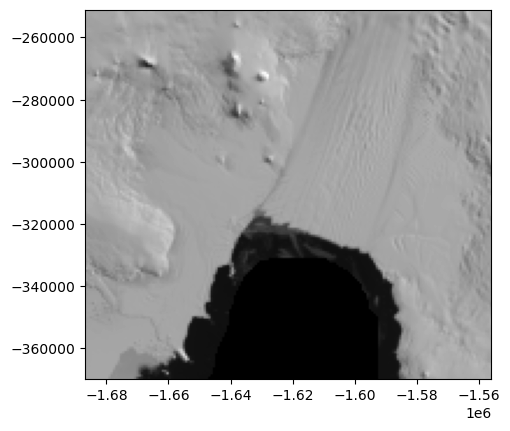

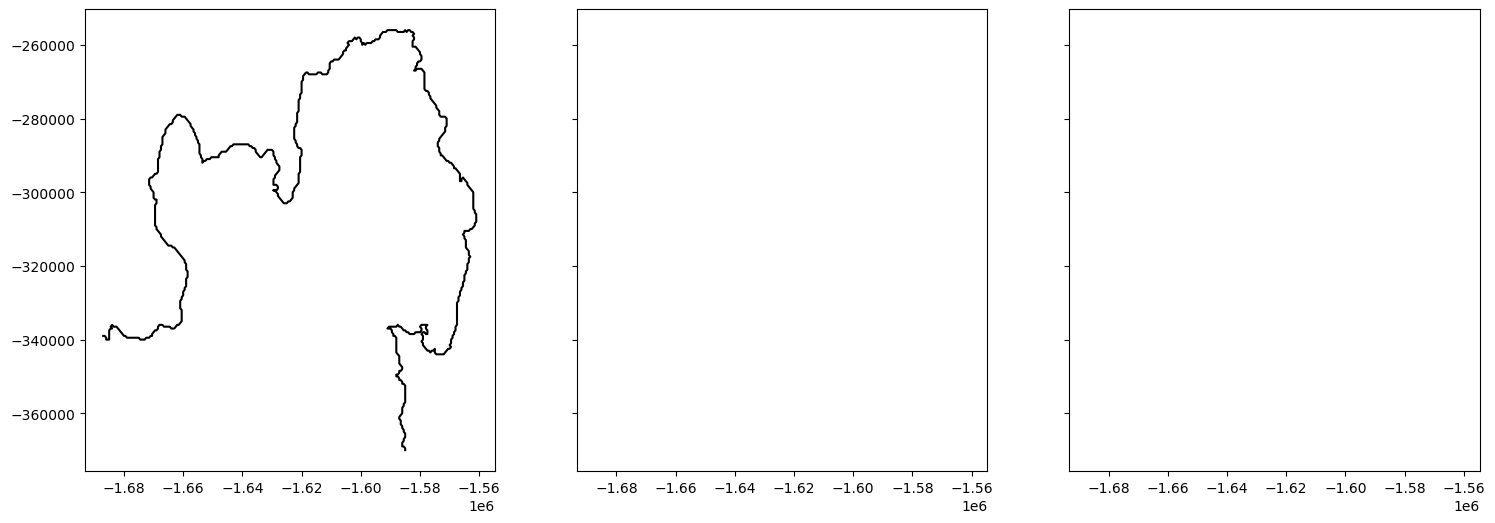

In [20]:
from importlib import reload
import pylab as plt
import numpy as np
from netCDF4 import Dataset
import matplotlib.cm as cm
from scipy.interpolate import RectBivariateSpline
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

import sys
#sys.path.append("/users/oliviasamolej/Desktop/REU/weakly-nonlinear-damage/Code/")
sys.path.append("/Users/jbassis/Documents/workspace/weakly-nonlinear-damage/Code/")
import amp_equation_tools;reload(amp_equation_tools);import amp_equation_tools as amp_equation
import stress_stream;reload(stress_stream);import stress_stream as stream

#from amp_eqn_integrate import integrate


plt.ion()


# Define material constants
rho_i = 918  # Density of ice (kg/m^3)
rho_w = 1028 # Density of ocean water (kg/m^3)
g = 9.81     # Acceleration due to gravity (m/s^2)
n = 3.       # Flow law exponent (dimensionless)

# Open ALL netcdf files with the year you want to compare
files = {
    '2010': '/users/oliviasamolej/Desktop/REU/ASE_domain/passdam_totNye_noMuCoeff_2010_500m.nc',
    '2050': '/users/oliviasamolej/Desktop/REU/ASE_domain/passdam_totNye_noMuCoeff_2050_500m.nc',
    '2100': '/users/oliviasamolej/Desktop/REU/ASE_domain/passdam_totNye_noMuCoeff_2100_500m.nc'
}
files = {
    '2010': '/Users/jbassis/Documents/workspace/weakly_nonlinear/data/passdam_totNye_noMuCoeff_2010_500m.nc',
}
# Store data for each year  
data = {}

for year, fname in files.items():
    try:
        nc = Dataset(fname, 'r')
    except FileNotFoundError:
        print(f"Error: File not found at {fname}")
        continue

    ######################################################
    # Extract variables from netcdf BISICLES file
    # (x,y) coordinates of BISICLES points
    x = nc.variables['x'][:]
    y = nc.variables['y'][:]
    
    # Grid Spacing 
    dx = np.diff(x)[0]

    # Extract fields
    # (vx,vy) velocities (m/a)
    vx = nc.variables['xVel'][:]
    vy = nc.variables['yVel'][:]
    
    # Dimensionless variable S0
    S0 = nc.variables['s0_principal_stress'][:]
    
    # Nye crevasse depth/ice thickness (dimensionless)
    Nye = 1 / nc.variables['s0_principal_stress_transverse'][:]

    # Components of strain rates (unites year^{-1})
    Exx = nc.variables['strain_rate_xx'][:]
    Eyy = nc.variables['strain_rate_yy'][:]
    Exy = nc.variables['strain_rate_xy'][:]

    strain_rate = (Exx + Eyy)/2 +np.sqrt( ((Exx-Eyy))**2/ 4 + Exy**2 )

    
    # Damage as computed by Sam in BISICLES file
    dam = nc.variables['dam'][:]

    # Mask of where the ice is floating
    float_mask = nc.variables['float_mask'][:]

    # Mask of floating portions of Pine Island Glacier
    pg = nc.variables['pig_mask'][:]

    # Mask of floation portions of Thwaites glacier
    tw = nc.variables['thw_mask'][:]

    # Ice thickness from Sam's file
    thick = nc.variables['thk'][:]

    # Melt from Sam's file
    melt = nc.variables['melt_rate'][:]

    ################################################
    # Compute largest and smallest principal stress from strain rate components
    E1 = 0.5*(Exx + Eyy) + np.sqrt(0.25*(Exx - Eyy)**2 + Exy**2)
    E2 = 0.5*(Exx + Eyy) - np.sqrt(0.25*(Exx - Eyy)**2 + Exy**2)

    # Compute melt rate in steady state
    melt = -(np.gradient(vx * thick, dx, dx)[1] + np.gradient(vy * thick, dx, dx)[0])

    
    ############################################################
    # Bilinearly interpolate variables.  This allows us to calculate variables at off grid locations
    interpolators = {
        's0': RectBivariateSpline(x, y, S0.T),
        'vx': RectBivariateSpline(x, y, vx.T),
        'vy': RectBivariateSpline(x, y, vy.T),
        'thk': RectBivariateSpline(x, y, thick.T),
        'E1': RectBivariateSpline(x, y, E1.T),
        'E2': RectBivariateSpline(x, y, E2.T),
        'melt': RectBivariateSpline(x, y, melt.T),
        'Nye': RectBivariateSpline(x, y, Nye.T),
        'dam': RectBivariateSpline(x, y, dam.T),
        'strain_rate': RectBivariateSpline(x, y, strain_rate.T),
    }

    # Store everything
    data[year] = {
        'x': x, 'y': y, 'dx': dx,
        'vx': vx, 'vy': vy, 'thk': thick,
        'E1': E1, 'E2': E2, 'S0': S0, 'Nye': Nye,
        'dam': dam, 'melt': melt,
        'interpolators': interpolators,
        'float_mask': float_mask, 'pig_mask': pg, 'thw_mask': tw
    }

###########################################################
# Read dataset with grounding line points for Pine Island
#xyValues = np.loadtxt('/users/oliviasamolej/Desktop/REU/ASE_domain/pig_groundingline_epsg3031_500m.csv')
xyValues = np.loadtxt('/Users/jbassis/Documents/workspace/weakly_nonlinear/data/pig_groundingline_epsg3031_500m.csv')

kinit = np.pi/4  # try pi/2
Ainit = 0.05  # should be less than 1
t = 0.0  

#img=rasterio.open("/users/oliviasamolej/Desktop/REU/Research/MODIS-code&data/moa750_2014_hp1_v01.tif")
img=rasterio.open("/Users/jbassis/Documents/workspace/weakly_nonlinear/data/moa750_2014_hp1_v01.tif")

left = np.min(xyValues[:, 0])
right = np.max(xyValues[:, 0])+5000
bottom = np.min(xyValues[:, 1])
top = np.max(xyValues[:, 1])+5000


rst = img.read(1, window=from_bounds(left, bottom, right, top, img.transform))

plt.imshow(rst,cmap='Greys_r',extent=(left, right, bottom, top),rasterized=True)

def advect_damage_flowlines(interpolators, xyValues, min_flow_line_num, max_flow_line_num, year_label, ax, cmap='PuRd'):
    Nt = 10000
    dx_min = 500.0
    damage_lines = []
    flowlines = []
    flowlines_dist = []
    damage_lines_sam = []
    A = Ainit
    k = kinit
    damage = 0.0

    # This plots the grounding line on the given subplot
    ax.plot(xyValues[:, 0] , xyValues[:, 1] , 'k')

    for flow_line_num, x_start in enumerate(xyValues[min_flow_line_num:max_flow_line_num, :], 1):
        x = x_start.copy()
        xs = []
        dams = []
        dam_sam = []
        melts = []
        thicks = []
        amp = []
        wave = []

        for i in range(Nt):
            try:
                vx = interpolators['vx'].ev(x[0], x[1])
                vy = interpolators['vy'].ev(x[0], x[1])
                thk = interpolators['thk'].ev(x[0], x[1])
                e1 = interpolators['E1'].ev(x[0], x[1])
                e2 = interpolators['E2'].ev(x[0], x[1])
                melt = interpolators['melt'].ev(x[0], x[1])
                s0 = interpolators['s0'].ev(x[0], x[1])
                rn = interpolators['Nye'].ev(x[0], x[1])
                dam_val = interpolators['dam'].ev(x[0], x[1])
                strain = interpolators['strain_rate'].ev(x[0], x[1])
            except:
                break

            if thk < 100:
                break

            if i == 0:
                r = np.clip(rn, 0, 1)
            else:
                r = np.clip(np.maximum(r, rn), rn, 1)

            speed = np.sqrt(vx**2 + vy**2)
            dt = dx_min / speed
            x += np.array([vx, vy]) * dt

            #A_new, damage, k_new = integrate(dt, k, A, s0, melt, thk, strain)
            Scrit,funcs,amp_eqn=amp_equation.solveAmpEqn(k,ms=0.0,mb=melt/(thk*e1),n=3)
            dAdt=amp_eqn(S=s0,A=A,order=5)
            if np.isnan(dAdt)==False:
                A += dAdt*(dt*np.abs(e1))
                k = k*np.exp(-dt*(2*e1)-dt*melt/thk)
            
            
            if np.isnan(A)==True:
                A=0.0
            A = np.minimum(np.maximum(A,0),1)
            damage = np.array(stream.amp2dam(k,[A],funcs)).item()
            damage = np.clip(damage,0,1)
            print("amplitude",A,"damage",damage,"wavenumber",k,"dAdt",dAdt)
            
            
            
            
            xs.append(x.copy())
            dams.append(damage)
            dam_sam.append(dam_val)
            melts.append(melt)
            thicks.append(thk)
            amp.append(A)
            wave.append(k)

        xs_array = np.array(xs)
        xs_array = np.array(xs)

       # Skip malformed or too-short flowlines
        if xs_array.ndim != 2 or xs_array.shape[0] < 2:
            continue

        dist = np.r_[0, np.cumsum(np.sqrt(np.sum(np.diff(xs_array, axis=0)**2, axis=1)))]

        # Collect all flowline points for a single scatter call
        all_xs.extend(xs_array[:, 0])
        all_ys.extend(xs_array[:, 1])
        all_dams.extend(dams)

        damage_lines.append(dams)
        damage_lines_sam.append(dam_sam)
        flowlines.append(xs_array)
        flowlines_dist.append(dist)

    # Plot all flowline points together with transparency
    sc = ax.scatter(all_xs, all_ys, s=5, c=all_dams, cmap=cmap, vmin=0, vmax=1, alpha=0.4)


    return damage_lines, damage_lines_sam, flowlines, flowlines_dist, sc

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

#21 - 55
flowline_range = (0, len(xyValues))
titles = ['2010', '2050', '2100']
cmaps = ['PuRd', 'PuRd', 'PuRd']
years = ['2010', '2050', '2100']
colorbars = []

for ax, year, cmap, title in zip(axs, years, cmaps, titles):
    damage_lines, damage_sam, flowlines, flowlines_dist, sc = advect_damage_flowlines(
        interpolators=data[year]['interpolators'],
        xyValues=xyValues,
        min_flow_line_num=flowline_range[0],
        max_flow_line_num=flowline_range[1],
        year_label=title,
        ax=ax,
        cmap=cmap
    )

    ax.set_title(f"Flowline Damage - {title}")
    ax.set_xlabel('x (km)')
    if ax == axs[0]:
        ax.set_ylabel('y (km)')
    colorbars.append(sc)

# Shared colorbar
cbar = fig.colorbar(colorbars[-1], ax=axs.ravel().tolist(), shrink=0.95)
cbar.set_label('Damage')

#plt.tight_layout()
plt.show()

    

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

#21 - 55
flowline_range = (0, len(xyValues))
titles = ['2010', '2050', '2100']
cmaps = ['PuRd', 'PuRd', 'PuRd']
years = ['2010', '2050', '2100']
colorbars = []

for ax, year, cmap, title in zip(axs, years, cmaps, titles):
    damage_lines, damage_sam, flowlines, flowlines_dist, sc = advect_damage_flowlines(
        interpolators=data[year]['interpolators'],
        xyValues=xyValues,
        min_flow_line_num=flowline_range[0],
        max_flow_line_num=flowline_range[1],
        year_label=title,
        ax=ax,
        cmap=cmap
    )

    ax.set_title(f"Flowline Damage - {title}")
    ax.set_xlabel('x (km)')
    if ax == axs[0]:
        ax.set_ylabel('y (km)')
    colorbars.append(sc)

# Shared colorbar
cbar = fig.colorbar(colorbars[-1], ax=axs.ravel().tolist(), shrink=0.95)
cbar.set_label('Damage')

#plt.tight_layout()
plt.show()